## Notebook to explore the performance of different toy models of superposition across various sparsity levels

Toy models: 
1. Simple - ReLU(x)
   a) Trained at various sparsity levels and inferring per feature
   b) Trained at S=0.99 and inference at various sparsity levels
   c) Trained at S=0.90 and inference at various sparsity levels
3. Simple - Relu(x) - One-hot
4. ReLU(x) - handcoded lucius
5. Apollo's model
6. Anthropic's


In [40]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_weight_bars, plot_input_output_response
from toy_cis.util import threshold_matrix, in_out_response


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

In [42]:
"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


## 1. Simple ReLU

MLP that computes: $y = ReLU(x)$

Linear map with 50 neurons: 

$$
h = ReLU(W_1x) \\
y' = W_2h
$$

Input: 100 features with a varying sparsity levels, meaning that any given feature has p = 0.01 of being active, where `x = rand(-1,1)`

Loss function: MSE (not weighted for now)

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

In [43]:
# 1. Training functions
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def gen_batch_sparse(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [44]:
"""1. Define SIMPLE RELU MODEL - 100 FEATURES, 50 NEURONS"""
layer_act_fns = [t.relu, lambda x: x]

simple_relu_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

"""Train simple ReLU model at different sparsity levels and plot performance"""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
n_steps = 40000
logging_freq = n_steps // 100

loss_data = []  # will store loss data
loss_feat_data = [] # will store loss data per feature

pbar = tqdm(sparsities, desc="Training over sparsities")
for s in pbar:
    # Train model
    relu_cis = Cis(simple_relu_cfg, device=device).to(device)
    optimizer = t.optim.Adam(relu_cis.parameters())
    losses = train(
        relu_cis,
        batch_sz,
        s,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )
    
    # Calculate mean loss per feature over a set of examples
    n_examples = 200
    losses = t.zeros((n_examples, relu_cis.cfg.n_feat), device=device)
    with t.no_grad():
        for feat in range(relu_cis.cfg.n_feat):
            x = t.zeros(
                n_examples, 
                relu_cis.cfg.n_instances, 
                relu_cis.cfg.n_feat, 
                device=device
            )
            x[:, :, feat] = rearrange(t.linspace(-1, 1, n_examples, device=device), "n -> n 1")
            y_true = t.relu(x)
            y = relu_cis.forward(x)
            losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()
    
    mean_losses = asnumpy(reduce(losses, "example feat -> feat", "mean"))
    for feat_idx, val in enumerate(mean_losses):
        loss_data.append({"sparsity": s, "feature_idx": feat_idx, "mean_loss": val})


"""Plot loss vs sparsity for the simple ReLU model - use 20 datapoints"""

# Convert loss_data to pandas dataframe for ease of plotting with seaborn
df_loss = pd.DataFrame(loss_data)

# Create figure of all sparsity values
fig = plt.figure(figsize=(15, 5))
sns.lineplot(data = df_loss, x = "sparsity", y = "mean_loss")
plt.xlabel('Sparsity')
plt.xticks(np.linspace(0.0,1.0,21), fontsize=10, rotation = 60)
plt.ylabel('Loss per feature')
plt.title('Simple ReLU model trained at varying S:loss vs sparsity')
plt.savefig("/workspace/relu_trainingSparsities_loss.png", dpi=300)
plt.show()


# Create figure of high sparsity values
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data = df_loss, x = "sparsity", y = "mean_loss")
plt.xlabel('Sparsity')
plt.xlim(0.79,1)
plt.xticks(sparsities[sparsities > 0.75], rotation = 45)
plt.ylabel('Loss per feature')
plt.title('Simple ReLU model  trained at varying S: loss vs sparsity')
plt.savefig("/workspace/relu_trainingSparsities_loss_HighS.png", dpi=300)
plt.show()

In [45]:
"""Train a ReLU at S=0.99 and assess performance at different sparsity levels"""

# 1. Train the simple ReLU model on S=0.99 input
relu_cis = Cis(simple_relu_cfg, device=device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 40000
logging_freq = n_steps // 100
optimizer = t.optim.Adam(relu_cis.parameters())

losses = train(
    relu_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)


Training:   0%|          | 0/40000 [00:00<?, ?it/s]

In [46]:
"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
n_steps = 80000
logging_freq = n_steps // 10

loss_data_simpleRelu99 = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 200
loss_data = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch_sparse(relu_cis, n_examples, s)
        
        # compute mean loss
        y = relu_cis.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_simpleRelu99.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})


Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

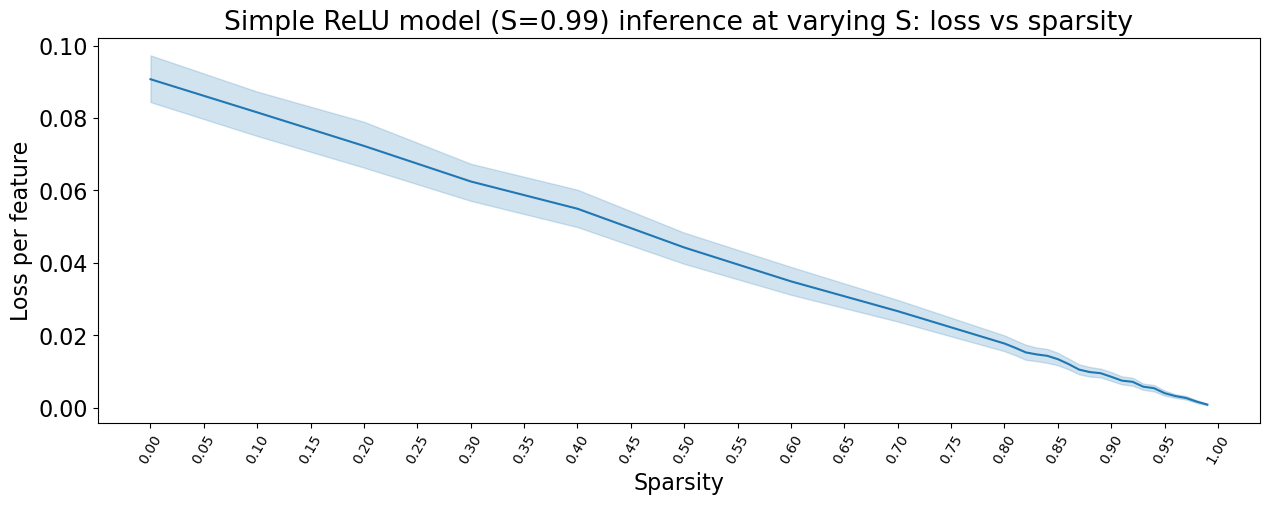

In [47]:
# Plot loss vs sparsity for simple ReLU trained at S=0.99

# Convert loss_data to pandas dataframe for ease of plotting with seaborn
df_loss = pd.DataFrame(loss_data_simpleRelu99)

# Create figure of all sparsity values
fig = plt.figure(figsize=(15, 5))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(np.linspace(0.0,1.0,21), fontsize=10, rotation = 60)
plt.ylabel('Loss per feature')
plt.title('Simple ReLU model (S=0.99) inference at varying S: loss vs sparsity')
plt.savefig("/workspace/S=099Relu_inferenceSparsity_loss.png", dpi=300)
plt.show()

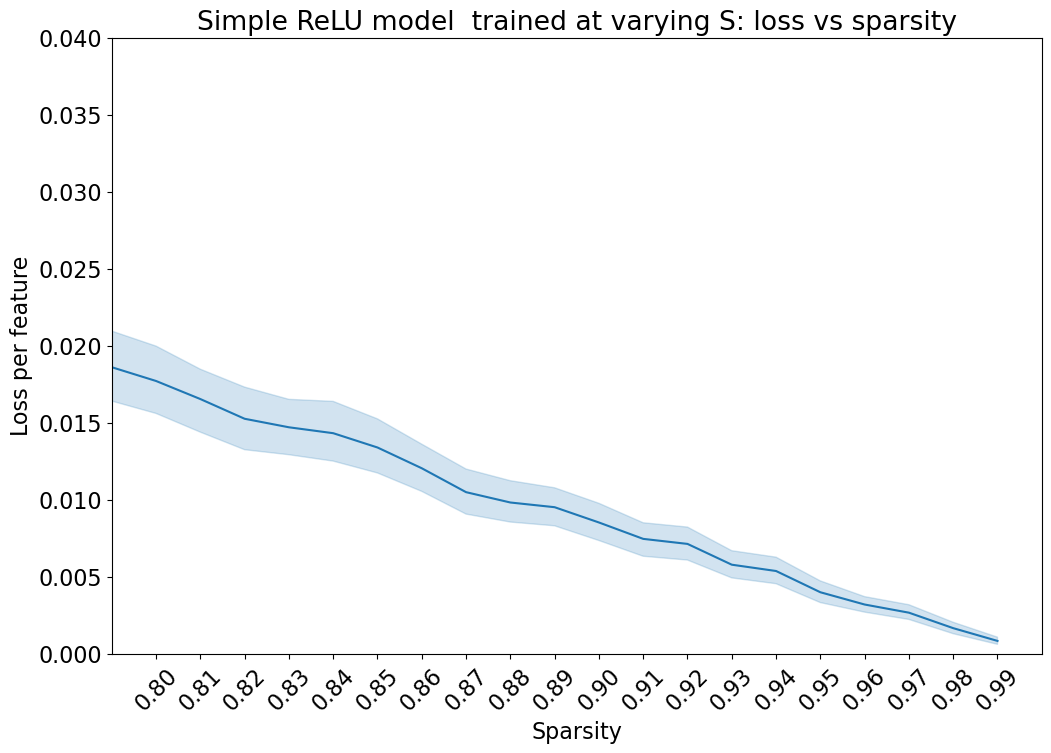

In [48]:
# Create figure of high sparsity values
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xlim(0.79,1)
plt.ylim(0,0.04)
plt.xticks(sparsities[sparsities > 0.75], rotation = 45)
plt.ylabel('Loss per feature')
plt.title('Simple ReLU model  trained at varying S: loss vs sparsity')
plt.savefig("/workspace/S=099Relu_inferenceSparsity_loss_HighS.png", dpi=300)
plt.show()

In [49]:
"""Train a ReLU at S=0.90 and assess performance at different sparsity levels"""

# 1. Train the simple ReLU model on S=0.90 input
relu_cis_90 = Cis(simple_relu_cfg, device=device)

batch_sz = 256
feat_sparsity = 0.90
feat_importance = 1
n_steps = 80000
logging_freq = n_steps // 100
optimizer = t.optim.Adam(relu_cis.parameters())

losses = train(
    relu_cis_90,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)

Training:   0%|          | 0/80000 [00:00<?, ?it/s]

In [50]:
"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
logging_freq = n_steps // 10

poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 200
loss_data_simpleRelu90 = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch_sparse(relu_cis_90, n_examples, s)
        
        # compute mean loss
        y = relu_cis_90.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_simpleRelu90.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

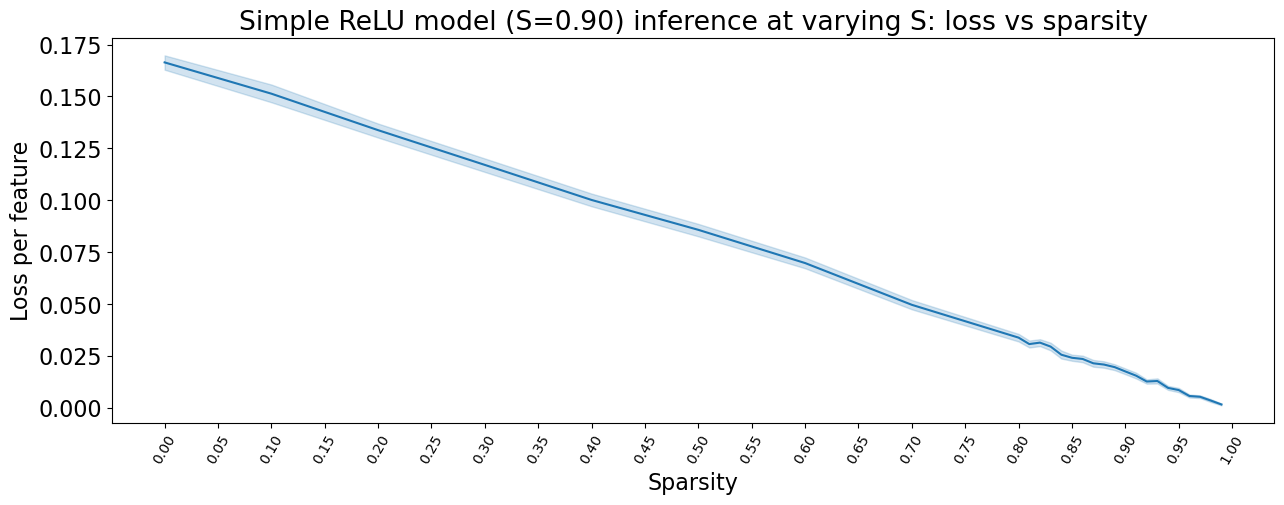

In [51]:
# Plot loss vs sparsity for simple ReLU trained at S=0.90

# Convert loss_data to pandas dataframe for ease of plotting with seaborn
df_loss = pd.DataFrame(loss_data_simpleRelu90)

# Create figure of all sparsity values
fig = plt.figure(figsize=(15, 5))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(np.linspace(0.0,1.0,21), fontsize=10, rotation = 60)
plt.ylabel('Loss per feature')
plt.title('Simple ReLU model (S=0.90) inference at varying S: loss vs sparsity')
plt.savefig("/workspace/S=090Relu_inferenceSparsity_loss.png", dpi=300)
plt.show()

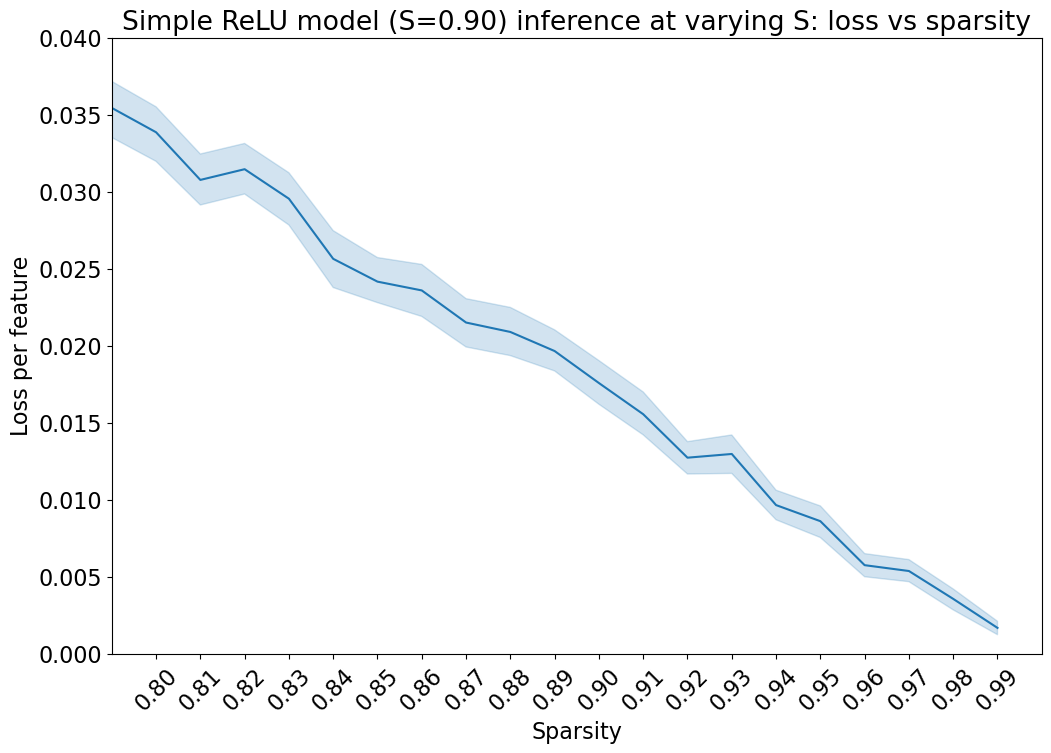

In [52]:
# Create figure of high sparsity values
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xlim(0.79,1)
plt.ylim(0,0.04)
plt.xticks(sparsities[sparsities > 0.75], rotation = 45)
plt.ylabel('Loss per feature')
plt.title('Simple ReLU model (S=0.90) inference at varying S: loss vs sparsity')
plt.savefig("/workspace/S=090Relu_inferenceSparsity_loss_HighS.png", dpi=300)
plt.show()

# 2. ReLU one hot

Target: 
$$
y = ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x) \\
y' = W_2h
$$

Input (one-hot vector):

$$
x = \text{randint}(-1, 1) \\
$$ 

Loss (weighted mse):

$$
\text{WMSE} = \frac{1}{N} \sum_{i=1}^{N} w_i \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
\text{where} \\[2ex]
w_i =
\begin{cases}
10, & \text{if } y_{\text{true},i} = 1, \\
1, & \text{otherwise}.
\end{cases}
$$

In [53]:
"""Create functions for generating batches, loss, and training for the one-hot model."""

def gen_batch(model: Cis, batch_sz: int) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    x = t.zeros(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device)
    active_positions = t.randint(
            0, model.cfg.n_feat, (batch_sz, model.cfg.n_instances), device=device
    )
    active_values = t.randint(0, 2, (batch_sz, model.cfg.n_instances), device=device) * 2.0 - 1
    
    # Create index tensors for vectorized assignment
    batch_idx = t.arange(batch_sz, device=device).view(-1, 1).expand(-1, model.cfg.n_instances)
    instance_idx = t.arange(model.cfg.n_instances, device=device).expand(batch_sz, -1)
    x[batch_idx, instance_idx, active_positions] = active_values
    
    return x, t.relu(x)

def gen_batch_sparse(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)
    
def loss_fn(y: Float[Tensor, "batch inst feat"], y_true: Float[Tensor, "batch inst feat"]) -> Float:
    active_weight, inactive_weight = 10, 1
    weights = t.where(y_true == 1, active_weight, inactive_weight)
    wmse = weights * (y - y_true) ** 2
    return reduce(wmse, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz)
        y = model.forward(x)
        loss = loss_fn(y, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [54]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

relu_onehot_cis_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

relu_onehot_cis = Cis(relu_onehot_cis_cfg, device=device).to(device)


batch_sz = 256
n_steps = 80000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(relu_onehot_cis.parameters())

losses = train(
    relu_onehot_cis,
    batch_sz,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/80000 [00:00<?, ?it/s]

[0.048882417380809784,
 0.004835155326873064,
 0.004178034607321024,
 0.004061117768287659,
 0.004404805134981871,
 0.004804517608135939,
 0.004525230266153812,
 0.004218044690787792,
 0.004319081082940102,
 0.00430757412686944,
 0.004163758829236031]

In [55]:
"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
logging_freq = n_steps // 10
poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 200
loss_data_oneHot = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch_sparse(relu_onehot_cis, n_examples, s)
        
        # compute mean loss
        y = relu_onehot_cis.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_oneHot.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})
        

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

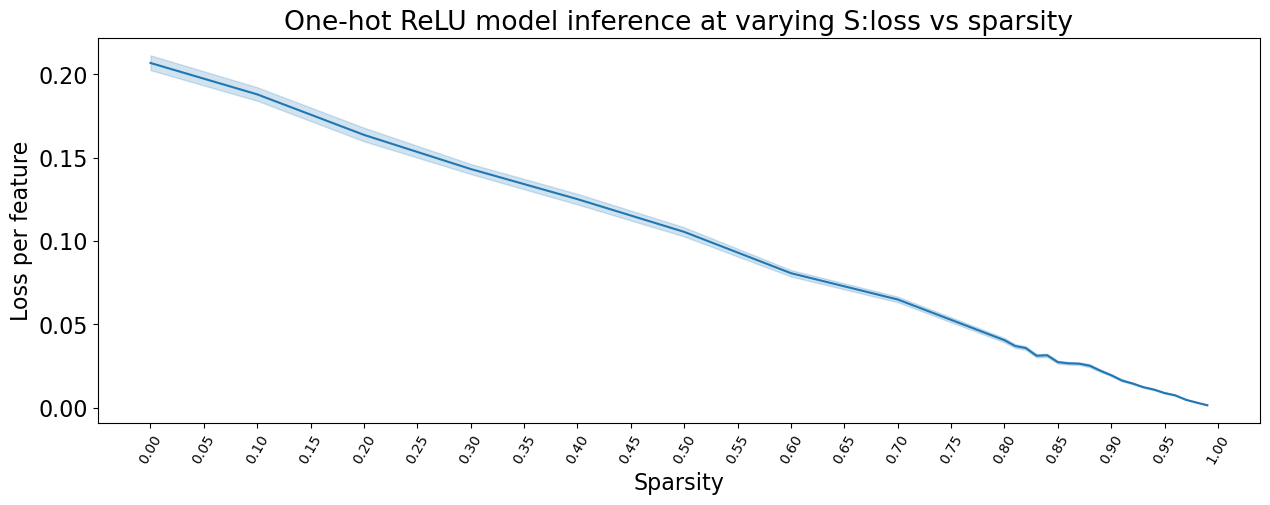

In [56]:
# Plot loss vs sparsity for one-hot ReLU model

# Convert loss_data to pandas dataframe for ease of plotting with seaborn
df_loss = pd.DataFrame(loss_data_oneHot)

# Create figure of all sparsity values
fig = plt.figure(figsize=(15, 5))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(np.linspace(0.0,1.0,21), fontsize=10, rotation = 60)
plt.ylabel('Loss per feature')
plt.title('One-hot ReLU model inference at varying S:loss vs sparsity')
plt.savefig("/workspace/oneHotRelu_inferenceSparsity_loss.png", dpi=300)
plt.show()

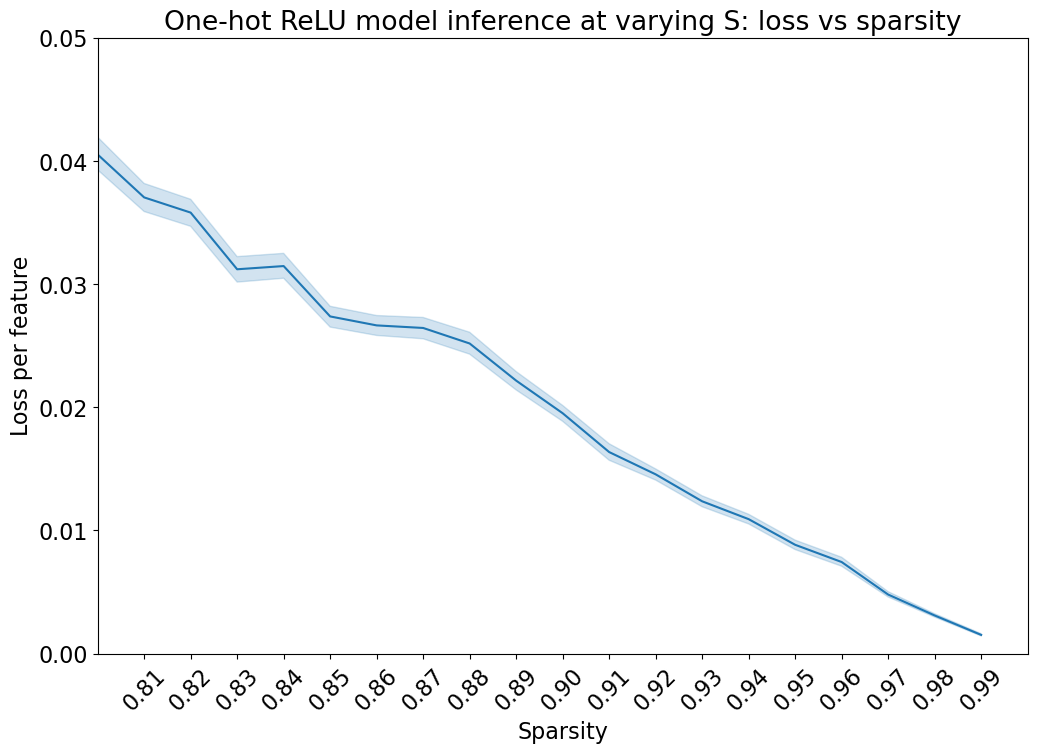

In [57]:
# Create figure of high sparsity values
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(sparsities[sparsities > 0.8], rotation = 45)
plt.xlim(0.8,1)
plt.ylim(0,0.05)
plt.ylabel('Loss per feature')
plt.title('One-hot ReLU model inference at varying S: loss vs sparsity')
plt.savefig("/workspace/oneHotRelu_inferenceSparsity_loss_HighS.png", dpi=300)
plt.show()

## 3. *reluPlusX_res_noEmbed*

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x) \\
y' = W_2h + x
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$



In [58]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def gen_batch_sparse(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [59]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_noEmbed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)

reluPlusX_res_noEmbed_cis = Cis(reluPlusX_res_noEmbed_cfg, device=device).to(device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 80000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(reluPlusX_res_noEmbed_cis.parameters())

losses = train(
    reluPlusX_res_noEmbed_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/80000 [00:00<?, ?it/s]

[0.001896586618386209,
 0.0010159568628296256,
 0.0008742809877730906,
 0.0008098117541521788,
 0.0009714339394122362,
 0.0007678561960346997,
 0.0008928568568080664,
 0.00099884660448879,
 0.0007436401792801917,
 0.000838098640087992,
 0.0007849290850572288]

In [60]:
"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
logging_freq = n_steps // 10

loss_data_reluPlusNoEmbed = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 200
loss_data = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch_sparse(reluPlusX_res_noEmbed_cis, n_examples, s)
        
        # compute mean loss
        y = reluPlusX_res_noEmbed_cis.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_reluPlusNoEmbed.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

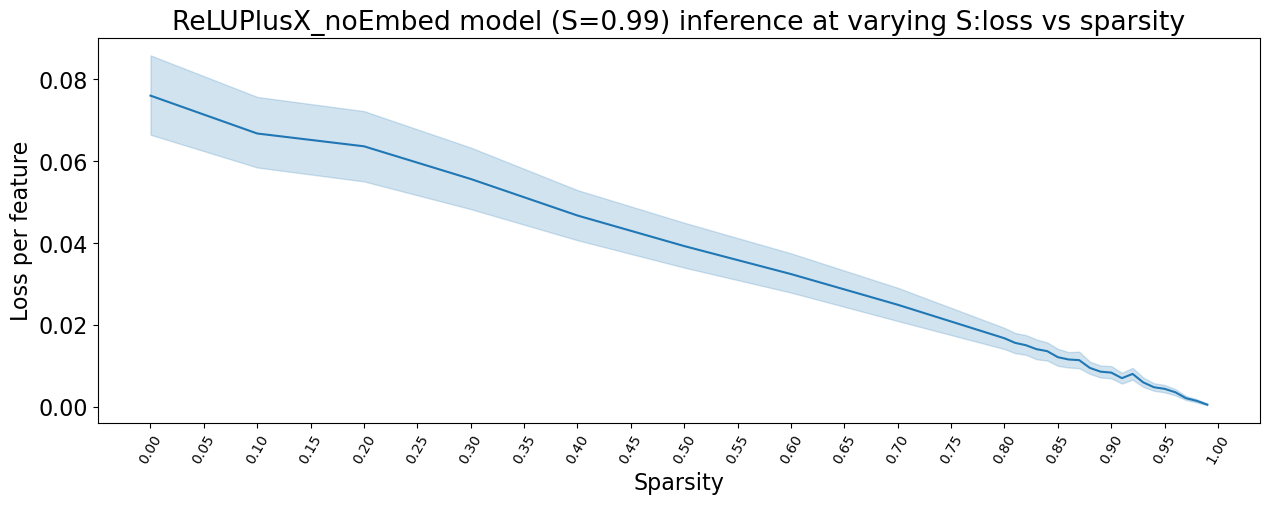

In [61]:
# Plot loss vs sparsity for one-hot ReLU model

# Convert loss_data to pandas dataframe for ease of plotting with seaborn
df_loss = pd.DataFrame(loss_data_reluPlusNoEmbed)

# Create figure of all sparsity values
fig = plt.figure(figsize=(15, 5))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(np.linspace(0.0,1.0,21), fontsize=10, rotation = 60)
plt.ylabel('Loss per feature')
plt.title('ReLUPlusX_noEmbed model (S=0.99) inference at varying S:loss vs sparsity')
plt.savefig("/workspace/ReLUplusNoEmbedS=099_inferenceSparsity_loss.png", dpi=300)
plt.show()

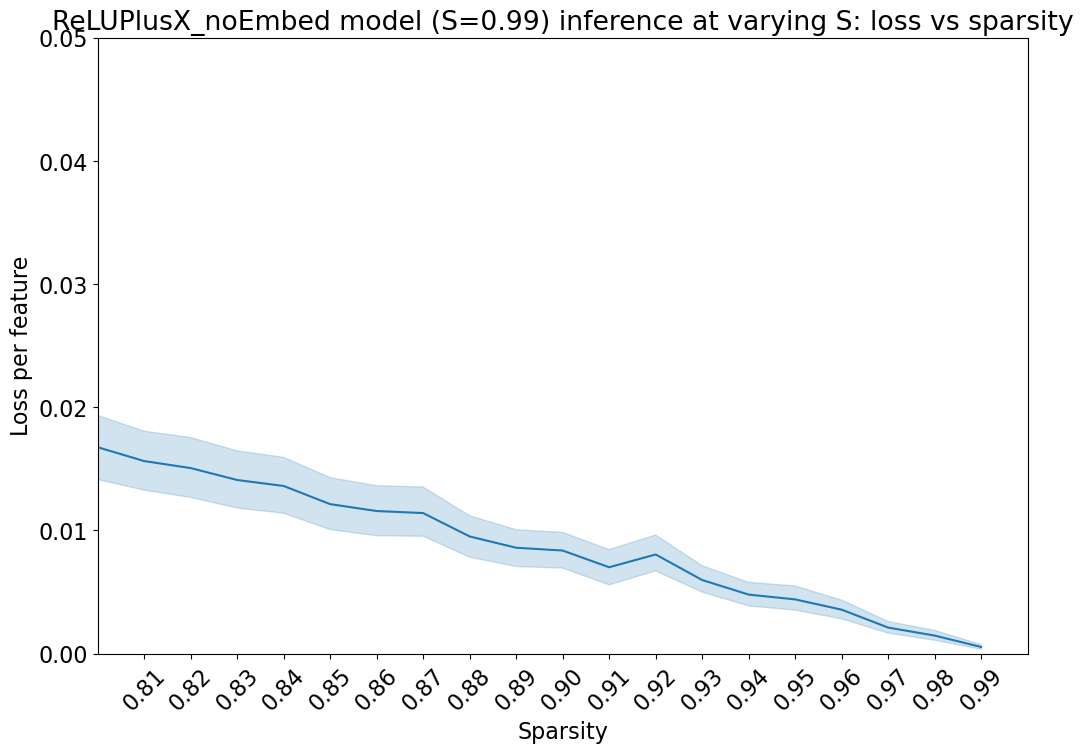

In [62]:
# Create figure of high sparsity values
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(sparsities[sparsities > 0.8], rotation = 45)
plt.xlim(0.8,1)
plt.ylim(0,0.05)
plt.ylabel('Loss per feature')
plt.title('ReLUPlusX_noEmbed model (S=0.99) inference at varying S: loss vs sparsity')
plt.savefig("/workspace/ReLUplusNoEmbedS=099_inferenceSparsity_loss_HighS.png", dpi=300)
plt.show()

Training:   0%|          | 0/80000 [00:00<?, ?it/s]

[0.016546133905649185,
 0.008191444911062717,
 0.008212890475988388,
 0.008430546149611473,
 0.007891805842518806,
 0.008194707334041595,
 0.00812109187245369,
 0.008319122716784477,
 0.007647864520549774,
 0.008042302913963795,
 0.007935010828077793]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

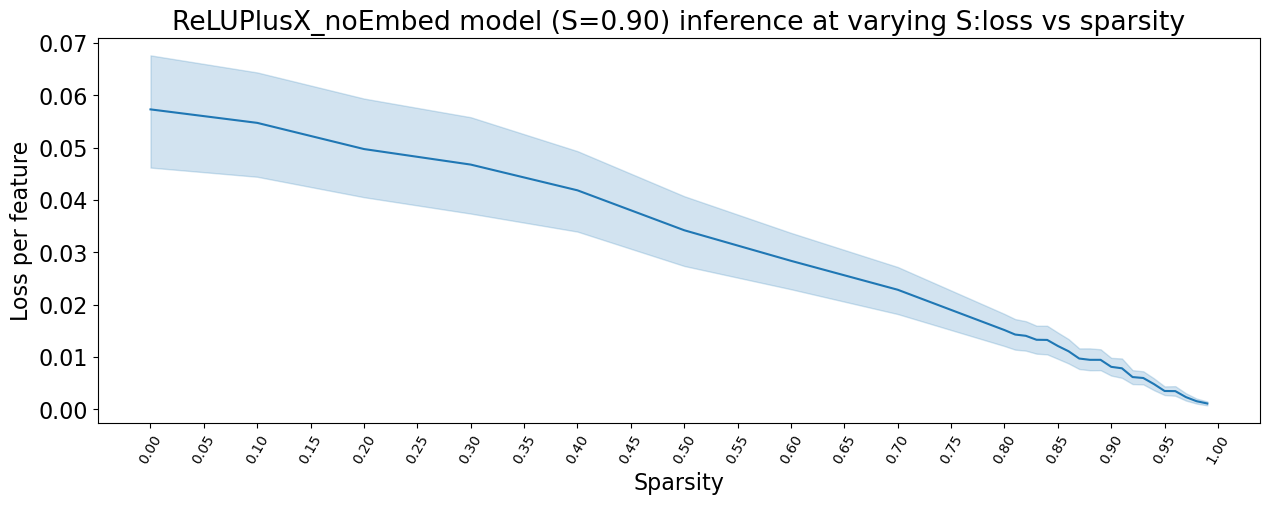

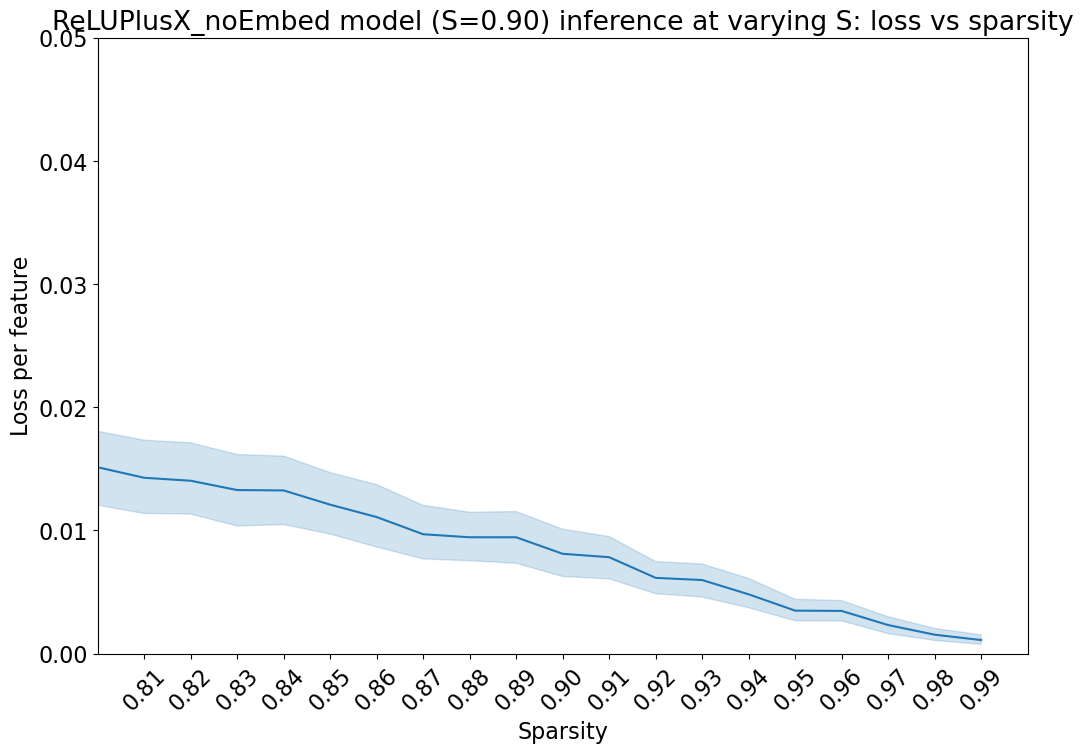

In [63]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_noEmbed_cfg90 = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)

reluPlusX_res_noEmbed_cis90 = Cis(reluPlusX_res_noEmbed_cfg90, device=device).to(device)

batch_sz = 256
feat_sparsity = 0.90
feat_importance = 1
n_steps = 80000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(reluPlusX_res_noEmbed_cis90.parameters())

losses = train(
    reluPlusX_res_noEmbed_cis90,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
logging_freq = n_steps // 10

loss_data_reluPlusNoEmbed90 = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 200
loss_data = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch_sparse(reluPlusX_res_noEmbed_cis90, n_examples, s)
        
        # compute mean loss
        y = reluPlusX_res_noEmbed_cis90.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_reluPlusNoEmbed90.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

# Plot loss vs sparsity for one-hot ReLU model

# Convert loss_data to pandas dataframe for ease of plotting with seaborn
df_loss = pd.DataFrame(loss_data_reluPlusNoEmbed90)

# Create figure of all sparsity values
fig = plt.figure(figsize=(15, 5))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(np.linspace(0.0,1.0,21), fontsize=10, rotation = 60)
plt.ylabel('Loss per feature')
plt.title('ReLUPlusX_noEmbed model (S=0.90) inference at varying S:loss vs sparsity')
plt.savefig("/workspace/ReLUplusNoEmbedS=090_inferenceSparsity_loss.png", dpi=300)
plt.show()

# Create figure of high sparsity values
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(sparsities[sparsities > 0.8], rotation = 45)
plt.xlim(0.8,1)
plt.ylim(0,0.05)
plt.ylabel('Loss per feature')
plt.title('ReLUPlusX_noEmbed model (S=0.90) inference at varying S: loss vs sparsity')
plt.savefig("/workspace/ReLUplusNoEmbedS=090_inferenceSparsity_loss_HighS.png", dpi=300)
plt.show()

## *reluPlusX_res_embed*

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
e = W_e x \\
h = ReLU(W_1 e) \\
u = W_2 h + x
y' = W_u u
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

In [64]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [65]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)

reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 80000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(reluPlusX_res_embed_cis.parameters(), lr=5e-4)

losses = train(
    reluPlusX_res_embed_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/80000 [00:00<?, ?it/s]

[0.0019223636481910944,
 0.000708937004674226,
 0.0006843215669505298,
 0.0006572440615855157,
 0.000680199998896569,
 0.0007223982247523963,
 0.0006088391528464854,
 0.0006250414298847318,
 0.0007510217255912721,
 0.0006349614704959095,
 0.0004977861535735428]

In [66]:
"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
logging_freq = n_steps // 10

poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 200
loss_data_reluPlusEmbed = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch_sparse(reluPlusX_res_embed_cis, n_examples, s)
        
        # compute mean loss
        y = reluPlusX_res_embed_cis.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_reluPlusEmbed.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

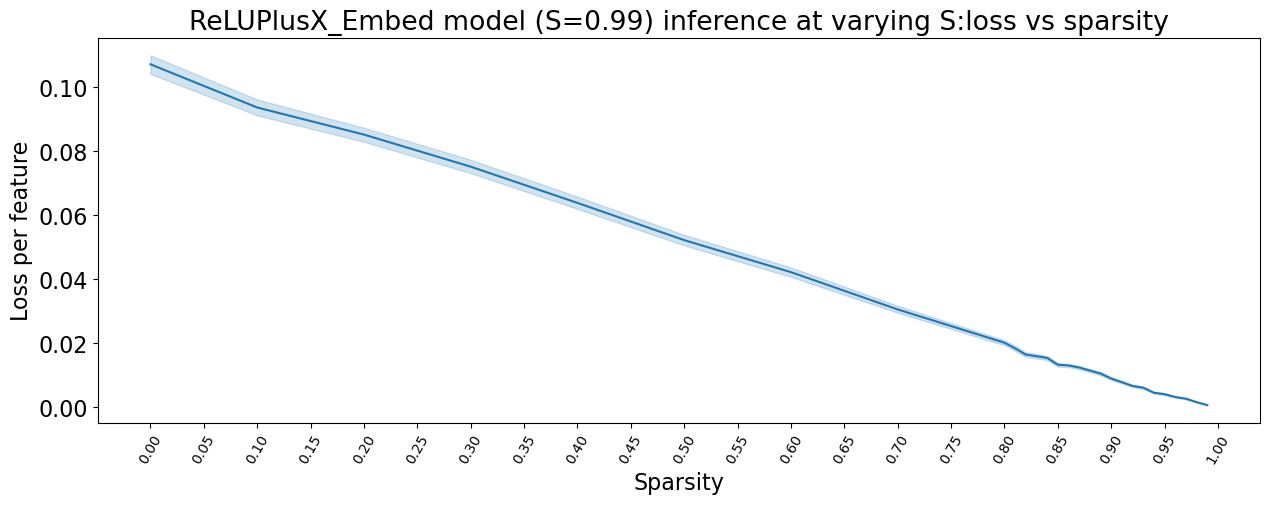

In [67]:
# Plot loss vs sparsity for one-hot ReLU model

# Convert loss_data to pandas dataframe for ease of plotting with seaborn
df_loss = pd.DataFrame(loss_data_reluPlusEmbed)

# Create figure of all sparsity values
fig = plt.figure(figsize=(15, 5))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(np.linspace(0.0,1.0,21), fontsize=10, rotation = 60)
plt.ylabel('Loss per feature')
plt.title('ReLUPlusX_Embed model (S=0.99) inference at varying S:loss vs sparsity')
plt.savefig("/workspace/ReLUplusEmbedS=099_inferenceSparsity_loss.png", dpi=300)
plt.show()

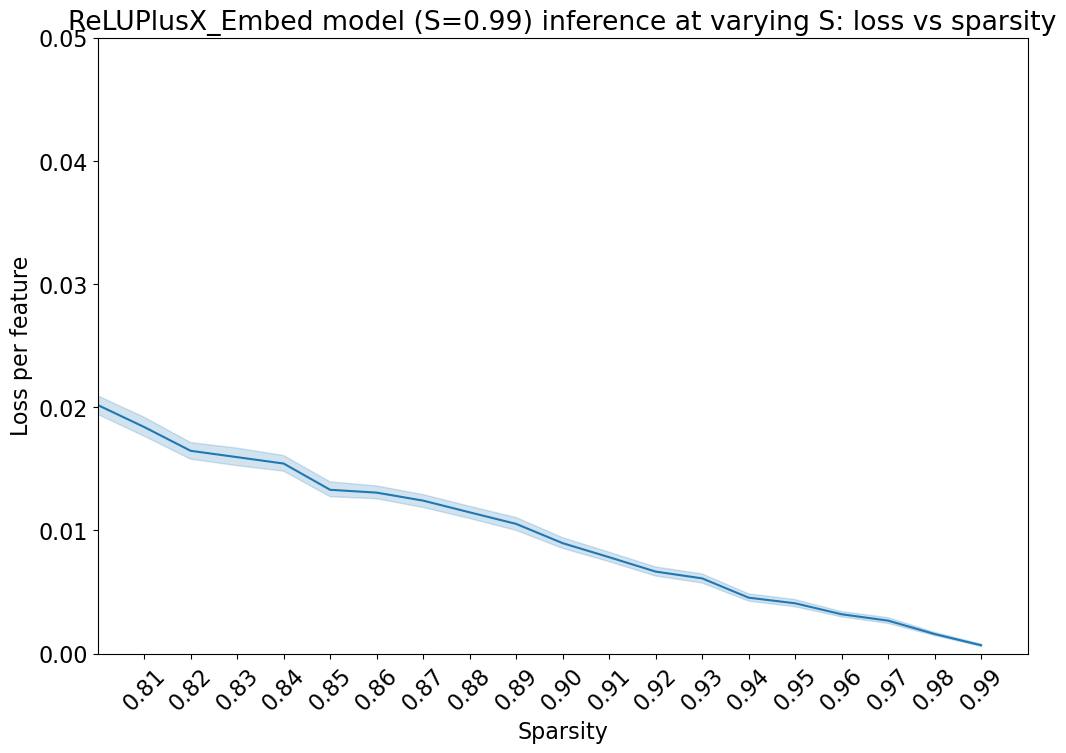

In [68]:
# Create figure of high sparsity values
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(sparsities[sparsities > 0.8], rotation = 45)
plt.xlim(0.8,1)
plt.ylim(0,0.05)
plt.ylabel('Loss per feature')
plt.title('ReLUPlusX_Embed model (S=0.99) inference at varying S: loss vs sparsity')
plt.savefig("/workspace/ReLUplusEmbedS=099_inferenceSparsity_loss_HighS.png", dpi=300)
plt.show()

Training:   0%|          | 0/80000 [00:00<?, ?it/s]

[0.018705355003476143,
 0.00778941810131073,
 0.008235326036810875,
 0.007875151000916958,
 0.007462413050234318,
 0.007747639436274767,
 0.007517723832279444,
 0.00782527681440115,
 0.007924774661660194,
 0.00795052107423544,
 0.0074668871238827705]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

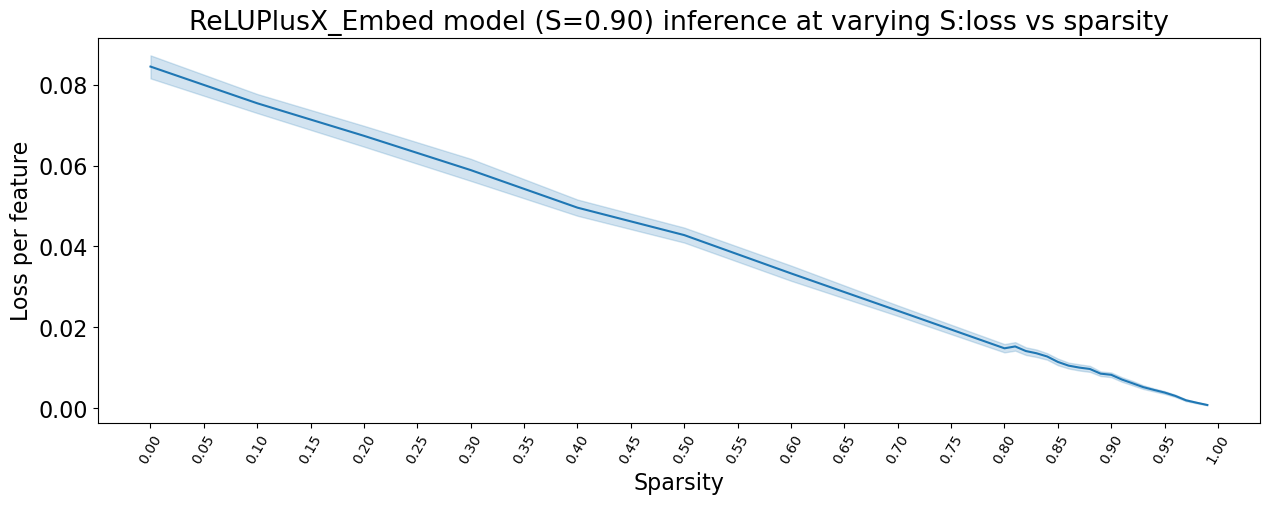

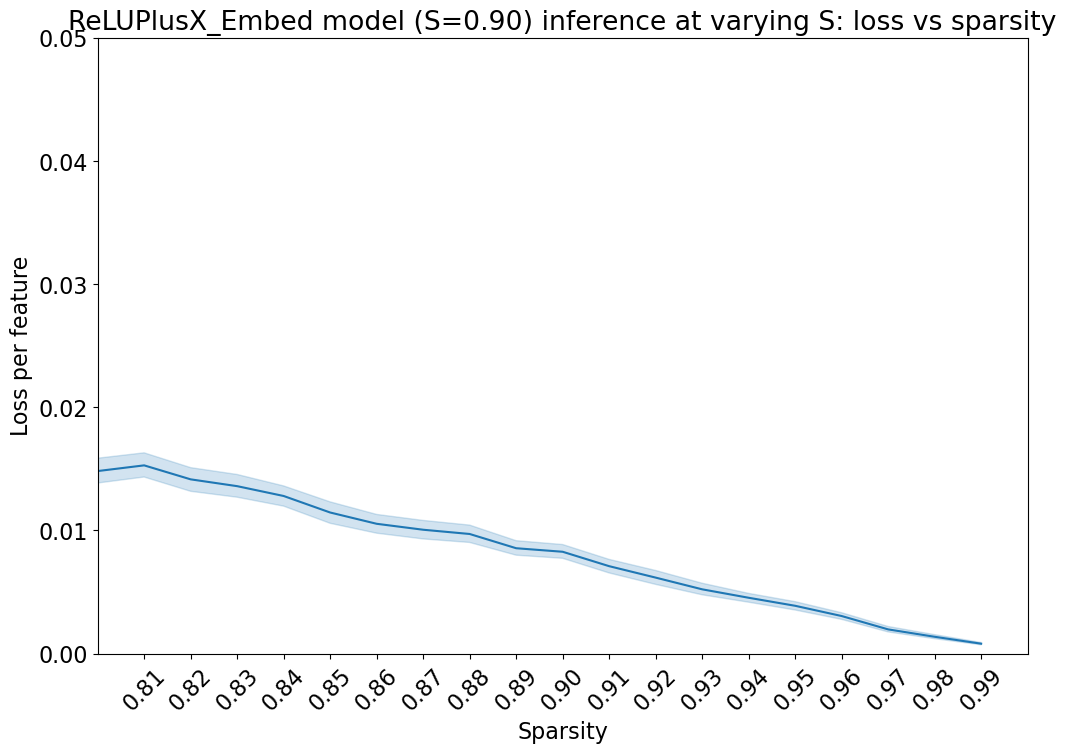

In [69]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg90 = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)

reluPlusX_res_embed_cis90 = Cis(reluPlusX_res_embed_cfg90, device=device)

batch_sz = 256
feat_sparsity = 0.90
feat_importance = 1
n_steps = 80000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(reluPlusX_res_embed_cis90.parameters(), lr=5e-4)

losses = train(
    reluPlusX_res_embed_cis90,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
logging_freq = n_steps // 10


pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 200
loss_data_reluPlusEmbed90 = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch_sparse(reluPlusX_res_embed_cis90, n_examples, s)
        
        # compute mean loss
        y = reluPlusX_res_embed_cis90.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_reluPlusEmbed90.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

# Plot loss vs sparsity for one-hot ReLU model

# Convert loss_data to pandas dataframe for ease of plotting with seaborn
df_loss = pd.DataFrame(loss_data_reluPlusEmbed90)

# Create figure of all sparsity values
fig = plt.figure(figsize=(15, 5))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(np.linspace(0.0,1.0,21), fontsize=10, rotation = 60)
plt.ylabel('Loss per feature')
plt.title('ReLUPlusX_Embed model (S=0.90) inference at varying S:loss vs sparsity')
plt.savefig("/workspace/ReLUplusEmbedS=090_inferenceSparsity_loss.png", dpi=300)
plt.show()

# Create figure of high sparsity values
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(sparsities[sparsities > 0.8], rotation = 45)
plt.xlim(0.8,1)
plt.ylim(0,0.05)
plt.ylabel('Loss per feature')
plt.title('ReLUPlusX_Embed model (S=0.90) inference at varying S: loss vs sparsity')
plt.savefig("/workspace/ReLUplusEmbedS=090_inferenceSparsity_loss_HighS.png", dpi=300)
plt.show()

## Put all loss vs sparsity plots together in one figure (simple relu S=0.99, simple relu S=0.9, relu_one_hot, reluPlusX_NoEmbed and reluPlusX_Embed)

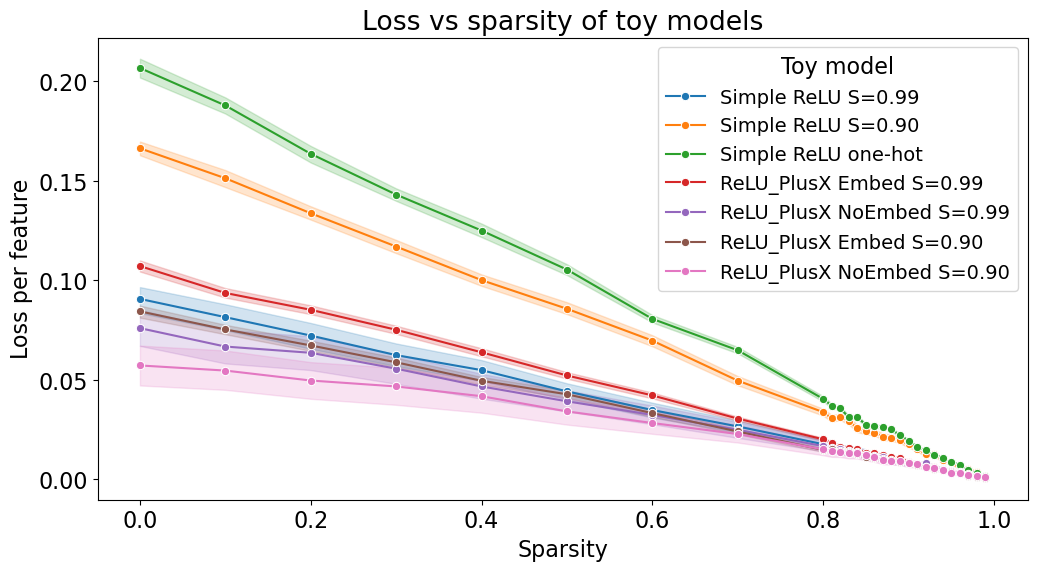

In [70]:
df1 = pd.DataFrame(loss_data_simpleRelu99)
df2 = pd.DataFrame(loss_data_simpleRelu90)
df3 = pd.DataFrame(loss_data_oneHot)
df4 = pd.DataFrame(loss_data_reluPlusEmbed)
df5 = pd.DataFrame(loss_data_reluPlusNoEmbed)
df6 = pd.DataFrame(loss_data_reluPlusEmbed90)
df7 = pd.DataFrame(loss_data_reluPlusNoEmbed90)
loss =  np.array([50 * (1 - sparsities) / 6])

# Add a column to track the origin of each DataFrame
df1['source'] = 'Simple ReLU S=0.99'
df2['source'] = 'Simple ReLU S=0.90'
df3['source'] = 'Simple ReLU one-hot'
df4['source'] = 'ReLU_PlusX Embed S=0.99'
df5['source'] = 'ReLU_PlusX NoEmbed S=0.99'
df6['source'] = 'ReLU_PlusX Embed S=0.90'
df7['source'] = 'ReLU_PlusX NoEmbed S=0.90'

# Combine all DataFrames
df_combined = pd.concat([df1, df2, df3, df4, df5, df6, df7])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='sparsity', y = "loss_per_feature", hue='source', marker='o')

# Add the equation as a dashed line
#plt.plot(sparsities, loss.ravel(), linestyle="dashed", color="red", label=r"Naive loss")

# Customize legend
plt.legend(title="Toy model", fontsize = 14)

# Labels & Title
plt.xlabel("Sparsity")
plt.ylabel("Loss per feature")
plt.title("Loss vs sparsity of toy models")

# Save and show plot
plt.savefig("/workspace/toyModels_inferenceSparsity_loss.png", dpi=300)
plt.show()

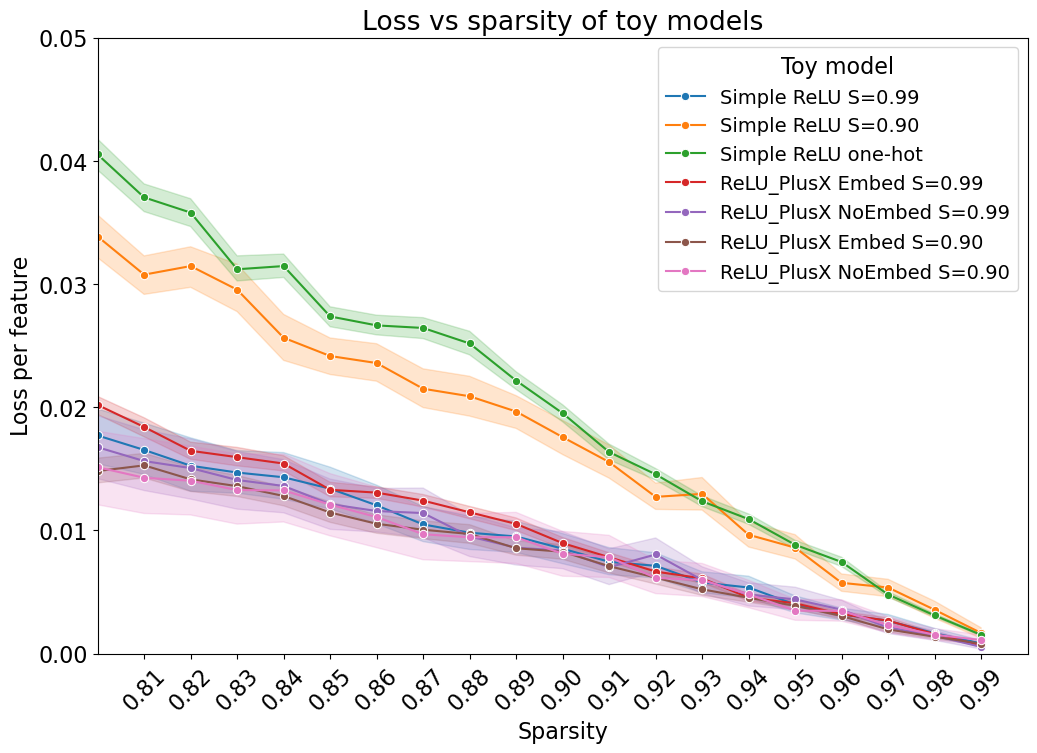

In [71]:
# Create figure of high sparsity values

fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=df_combined, x='sparsity', y = "loss_per_feature", hue='source', marker='o')
#plt.plot(sparsities, loss.ravel(), linestyle="dashed", color="red", label=r"Naive loss")
plt.legend(title="Toy model", fontsize = 14)
plt.xlabel('Sparsity')
plt.xticks(sparsities[sparsities > 0.8], rotation = 45)
plt.xlim(0.8,1)
plt.ylim(0,0.05)
plt.ylabel('Loss per feature')
plt.title("Loss vs sparsity of toy models")
plt.savefig("/workspace/toyModels_inferenceSparsity_loss_highS.png", dpi=300)
plt.show()

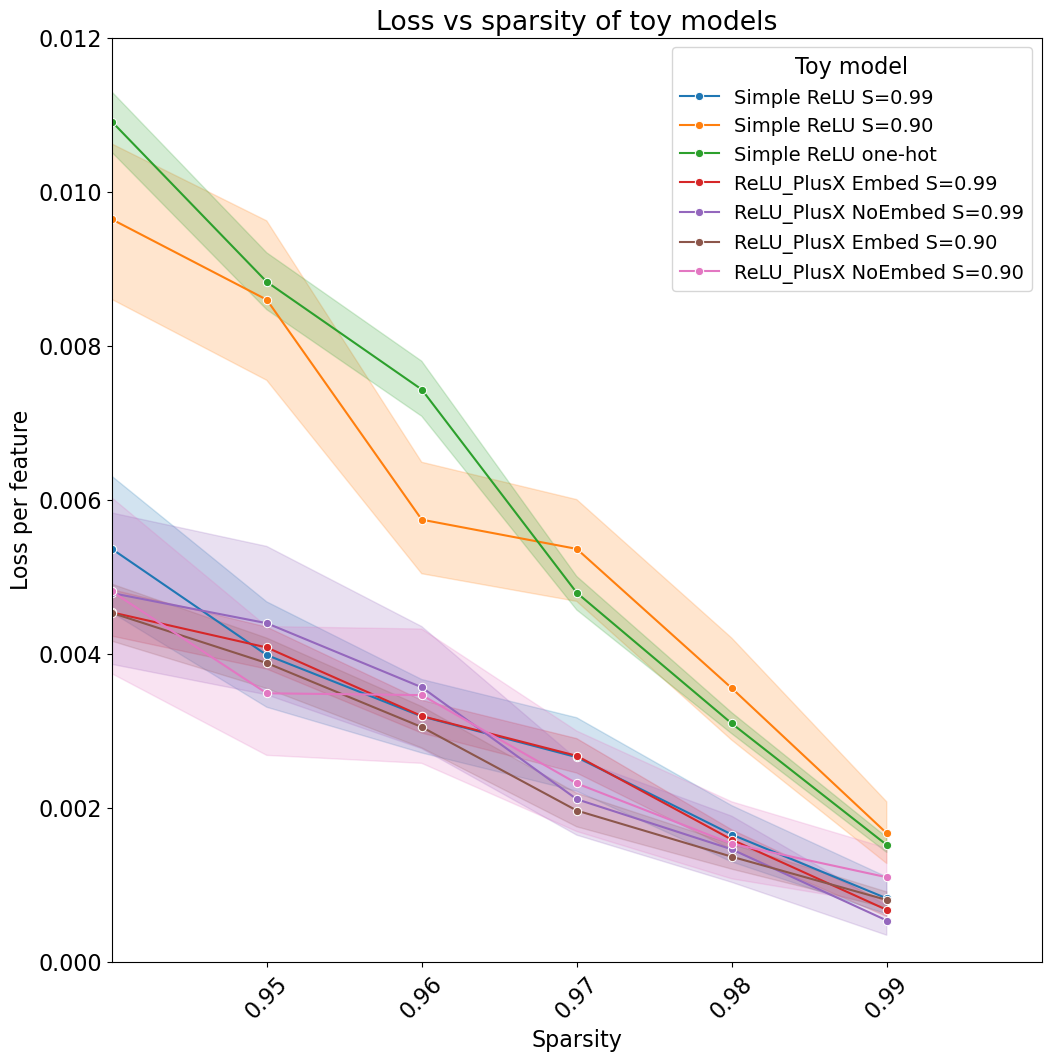

In [72]:
# Create figure of very high sparsity values

fig = plt.figure(figsize=(12, 12))
sns.lineplot(data=df_combined, x='sparsity', y = "loss_per_feature", hue='source', marker='o')
plt.legend(title="Toy model", fontsize = 14)
plt.xlabel('Sparsity')
plt.xticks(sparsities[sparsities > 0.94], rotation = 45)
plt.xlim(0.94,1)
plt.ylim(0,0.012)
plt.ylabel('Loss per feature')
plt.title("Loss vs sparsity of toy models")
plt.savefig("/workspace/toyModels_inferenceSparsity_loss_veryHighS.png", dpi=300)
plt.show()

## Anthropics abs(x) model

50 features and 50 neurons (because it takes two ReLU neurons to compute abs(x))

In [73]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.abs(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

Training:   0%|          | 0/80000 [00:00<?, ?it/s]

[0.00302562746219337,
 0.0007378438021987677,
 0.0006297996733337641,
 0.00034643596154637635,
 0.0007346199126914144,
 0.0008879360393621027,
 0.0007711654179729521,
 0.0004686634929385036,
 0.0010154317133128643,
 0.0005458341329358518,
 0.00048084065201692283]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

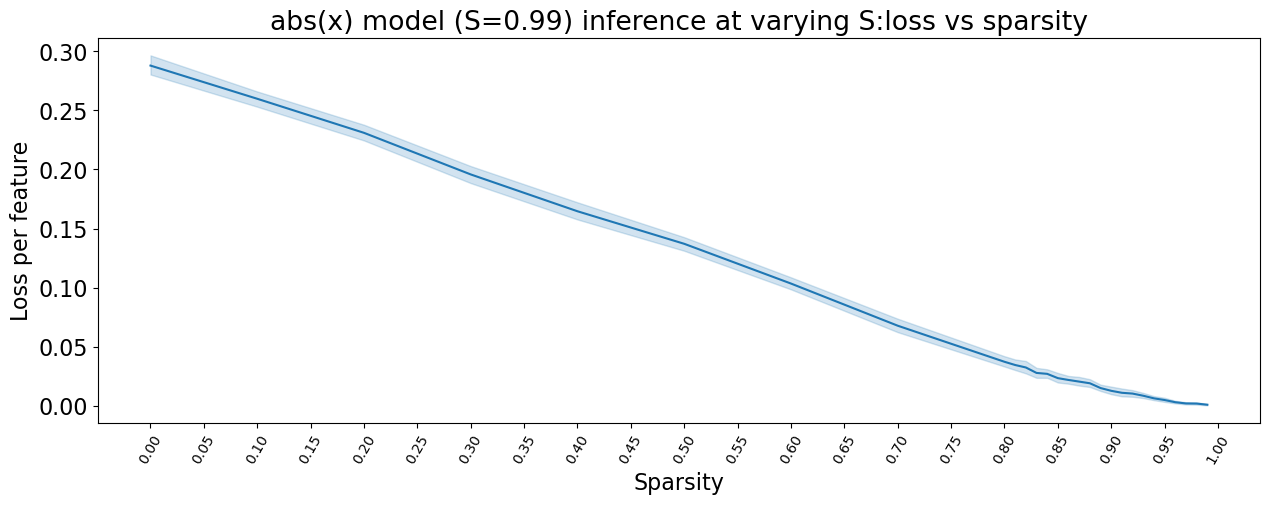

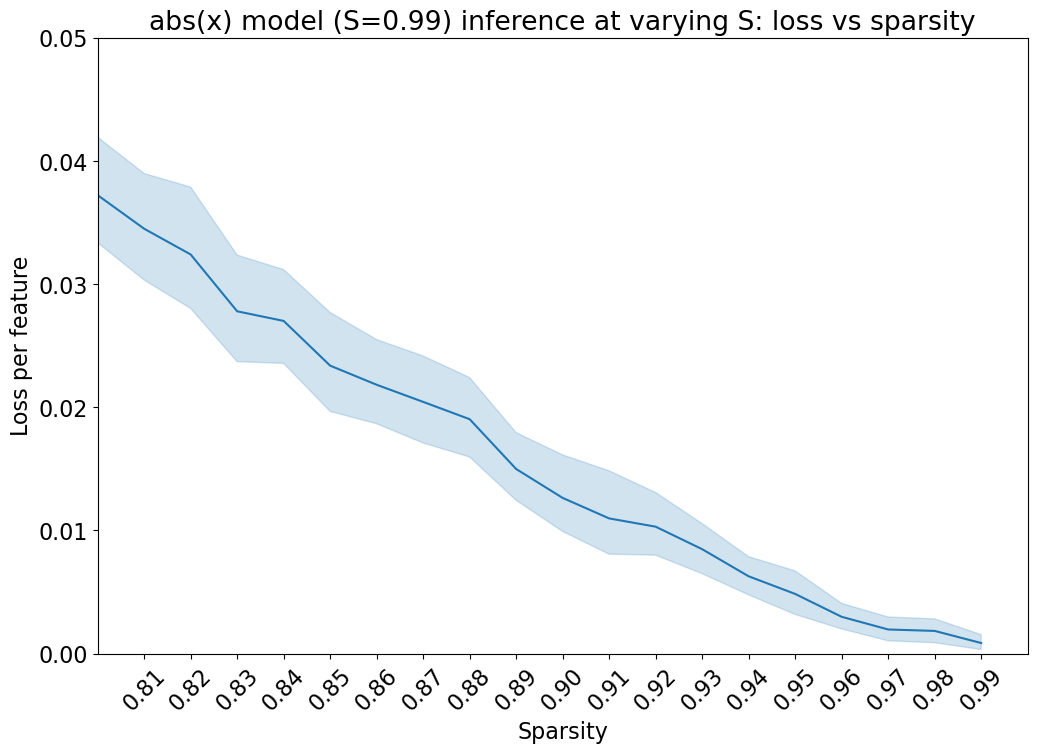

In [94]:
"""Create and train model."""

layer_act_fns = [t.relu, t.relu]

abs_cfg = CisConfig(
    n_instances=1,
    n_feat=50,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=0.0,
    skip_cnx=False,
    We_and_Wu=False,
)

abs_cis = Cis(abs_cfg, device=device).to(device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 80000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(abs_cis.parameters(), lr=5e-4)

losses = train(
    abs_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)


"""Get loss at inference over varying sparsity levels."""
sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
logging_freq = n_steps // 10


pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 200
loss_data_abs99 = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch(abs_cis, n_examples, s)
        
        # compute mean loss
        y = abs_cis.forward(x)
        loss = (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_abs99.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

# Plot loss vs sparsity for one-hot ReLU model

# Convert loss_data to pandas dataframe for ease of plotting with seaborn
df_loss = pd.DataFrame(loss_data_abs99)

# Create figure of all sparsity values
fig = plt.figure(figsize=(15, 5))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(np.linspace(0.0,1.0,21), fontsize=10, rotation = 60)
plt.ylabel('Loss per feature')
plt.title('abs(x) model (S=0.99) inference at varying S:loss vs sparsity')
plt.savefig("/workspace/absXS=099_inferenceSparsity_loss.png", dpi=300)
plt.show()

# Create figure of high sparsity values
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(sparsities[sparsities > 0.8], rotation = 45)
plt.xlim(0.8,1)
plt.ylim(0,0.05)
plt.ylabel('Loss per feature')
plt.title('abs(x) model (S=0.99) inference at varying S: loss vs sparsity')
plt.savefig("/workspace/absXS=099_inferenceSparsity_loss_HighS.png", dpi=300)
plt.show()

Training:   0%|          | 0/80000 [00:00<?, ?it/s]

[0.03142652288079262,
 0.010323276743292809,
 0.008003771305084229,
 0.007818656973540783,
 0.008963911794126034,
 0.007462333422154188,
 0.008251790888607502,
 0.00753659987822175,
 0.007492521777749062,
 0.008012950420379639,
 0.00823888834565878]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

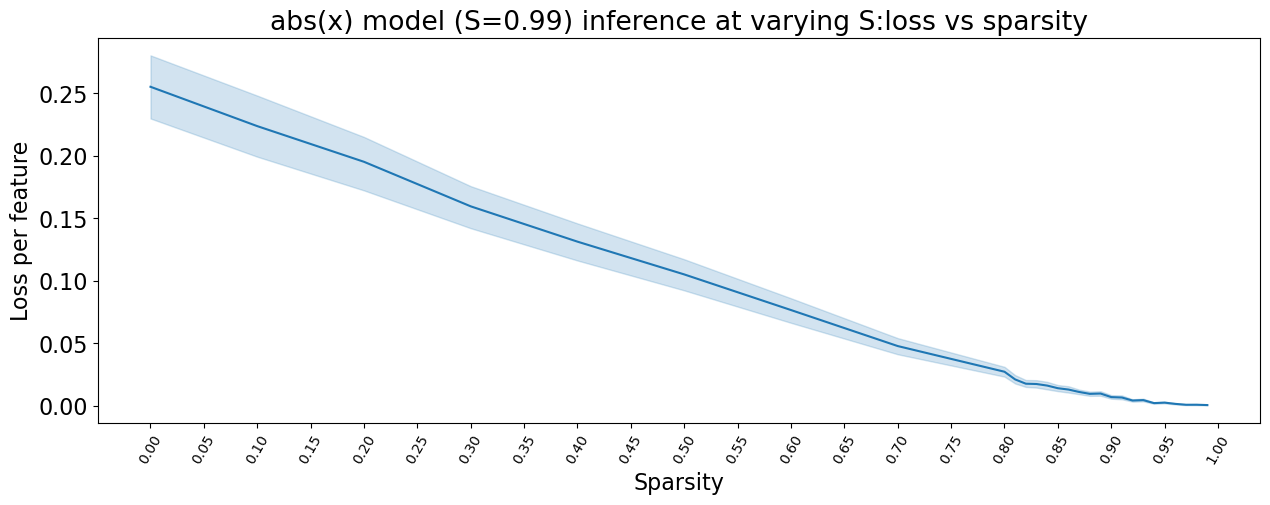

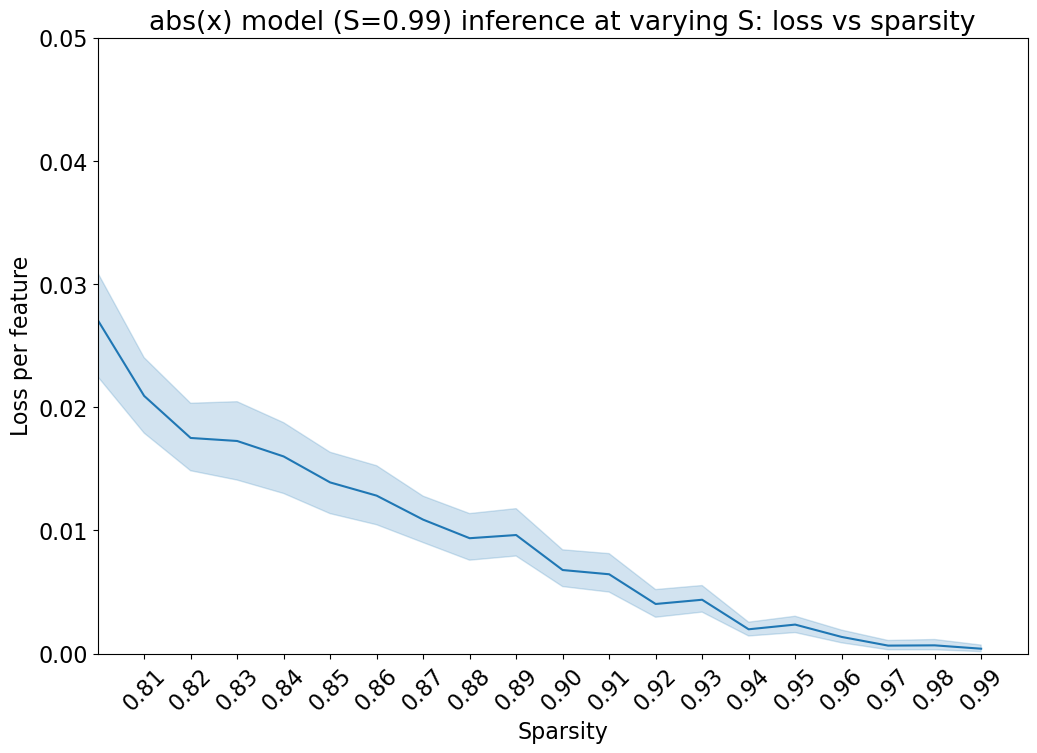

In [95]:
"""Create and train model."""

layer_act_fns = [t.relu, t.relu]

abs_cfg = CisConfig(
    n_instances=1,
    n_feat=50,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=0.0,
    skip_cnx=False,
    We_and_Wu=False,
)

abs_cis = Cis(abs_cfg, device=device).to(device)

batch_sz = 256
feat_sparsity = 0.90
feat_importance = 1
n_steps = 80000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(abs_cis.parameters(), lr=5e-4)

losses = train(
    abs_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)


"""Get loss at inference over varying sparsity levels."""
sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
logging_freq = n_steps // 10


pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 200
loss_data_abs90 = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch(abs_cis, n_examples, s)
        
        # compute mean loss
        y = abs_cis.forward(x)
        loss = (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_abs90.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

# Plot loss vs sparsity for one-hot ReLU model

# Convert loss_data to pandas dataframe for ease of plotting with seaborn
df_loss = pd.DataFrame(loss_data_abs90)

# Create figure of all sparsity values
fig = plt.figure(figsize=(15, 5))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(np.linspace(0.0,1.0,21), fontsize=10, rotation = 60)
plt.ylabel('Loss per feature')
plt.title('abs(x) model (S=0.99) inference at varying S:loss vs sparsity')
plt.savefig("/workspace/absXS=099_inferenceSparsity_loss.png", dpi=300)
plt.show()

# Create figure of high sparsity values
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data = df_loss, x = "sparsity", y = "loss_per_feature")
plt.xlabel('Sparsity')
plt.xticks(sparsities[sparsities > 0.8], rotation = 45)
plt.xlim(0.8,1)
plt.ylim(0,0.05)
plt.ylabel('Loss per feature')
plt.title('abs(x) model (S=0.99) inference at varying S: loss vs sparsity')
plt.savefig("/workspace/absXS=099_inferenceSparsity_loss_HighS.png", dpi=300)
plt.show()

## Plot Relu, ReluPlus and abs models 

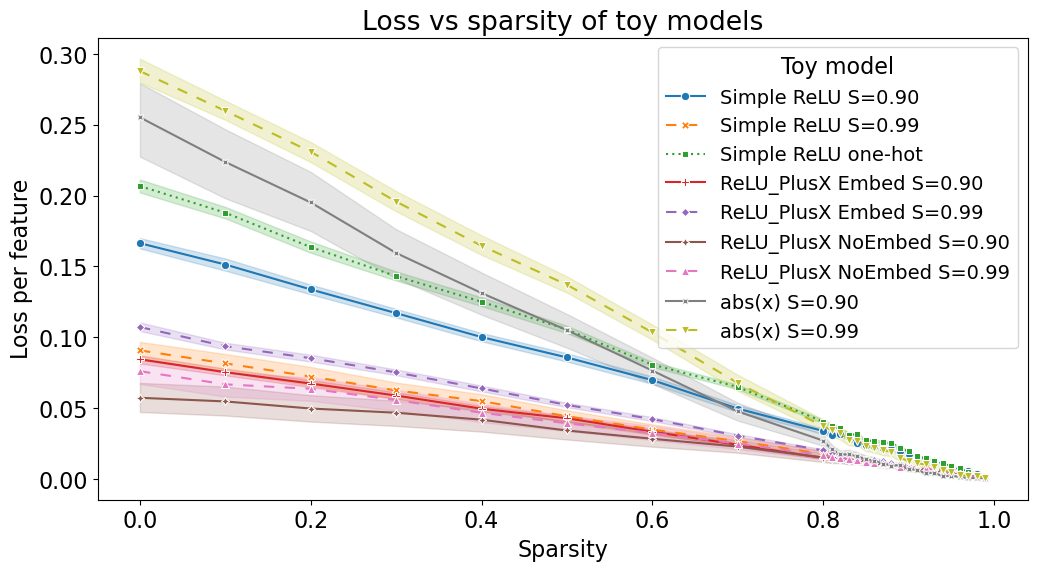

In [106]:
df1 = pd.DataFrame(loss_data_simpleRelu90)
df2 = pd.DataFrame(loss_data_simpleRelu99)
df3 = pd.DataFrame(loss_data_oneHot)
df4 = pd.DataFrame(loss_data_reluPlusEmbed90)
df5 = pd.DataFrame(loss_data_reluPlusEmbed)
df6 = pd.DataFrame(loss_data_reluPlusNoEmbed90)
df7 = pd.DataFrame(loss_data_reluPlusNoEmbed)
df8 = pd.DataFrame(loss_data_abs90)
df9 = pd.DataFrame(loss_data_abs99)

# Add a column to track the origin of each DataFrame
df1['source'] = 'Simple ReLU S=0.90'
df2['source'] = 'Simple ReLU S=0.99'
df3['source'] = 'Simple ReLU one-hot'
df4['source'] = 'ReLU_PlusX Embed S=0.90'
df5['source'] = 'ReLU_PlusX Embed S=0.99'
df6['source'] = 'ReLU_PlusX NoEmbed S=0.90'
df7['source'] = 'ReLU_PlusX NoEmbed S=0.99'
df8['source'] = 'abs(x) S=0.90'
df9['source'] = 'abs(x) S=0.99'

line_styles = {'Simple ReLU S=0.90': (None, None), 'Simple ReLU S=0.99': (5, 5), 'Simple ReLU one-hot':(1, 2) , 
               'ReLU_PlusX Embed S=0.90': (None, None), 'ReLU_PlusX Embed S=0.99': (5, 5),
              'ReLU_PlusX NoEmbed S=0.90': (None, None), 'ReLU_PlusX NoEmbed S=0.99': (5, 5),
               'abs(x) S=0.90': (None, None), 'abs(x) S=0.99': (5, 5),}

custom_palette = {
    'Simple ReLU S=0.90': '#4c72b0', 'Simple ReLU S=0.99': '#4c72b0', 'Simple ReLU one-hot':'#4c72b0', #muted blue
    'ReLU_PlusX Embed S=0.90': '#dd8452', 'ReLU_PlusX Embed S=0.99': '#dd8452', #soft orange
    'ReLU_PlusX NoEmbed S=0.90': '#55a868', 'ReLU_PlusX NoEmbed S=0.99': '#55a868',   #teal green
    'abs(x) S=0.90': '#c44e52', 'abs(x) S=0.99': '#c44e52' #dusty rose
}

# Combine all DataFrames
df_combined = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='sparsity', y = "loss_per_feature", hue='source', 
             style= 'source', dashes=line_styles, markers=True) #palette=custom_palette, 


# Customize legend
plt.legend(title="Toy model", fontsize = 14)

# Labels & Title
plt.xlabel("Sparsity")
plt.ylabel("Loss per feature")
plt.title("Loss vs sparsity of toy models")

# Save and show plot
plt.savefig("/workspace/toyModels_inferenceSparsity_lossv2.png", dpi=300)
plt.show()

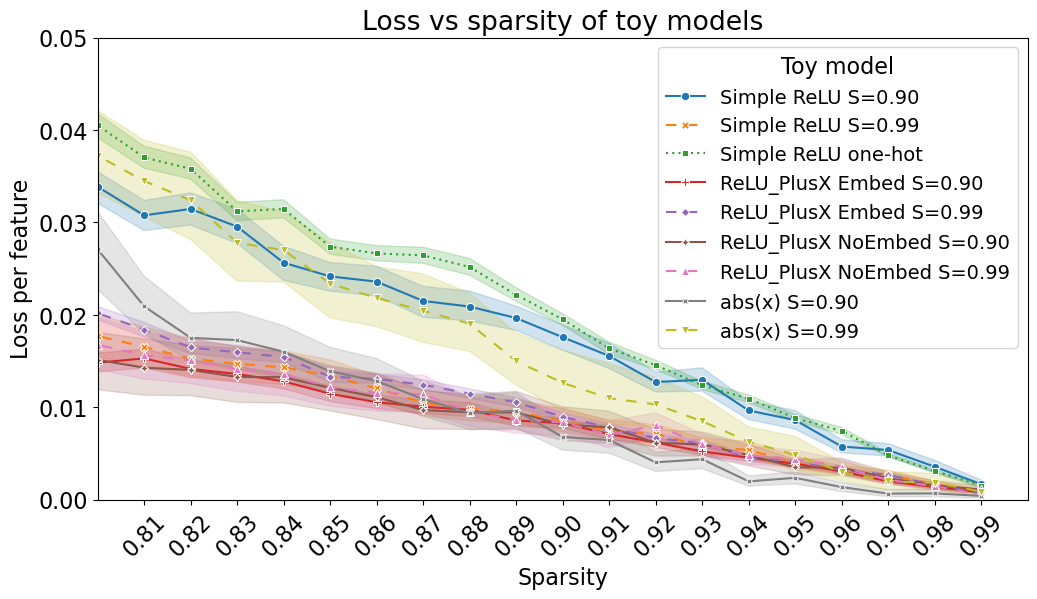

In [108]:
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='sparsity', y = "loss_per_feature", hue='source', 
             style= 'source', dashes=line_styles, markers=True)#palette=custom_palette, 


# Customize legend
plt.legend(title="Toy model", fontsize = 14)

# Labels & Title
plt.xlabel("Sparsity")
plt.xticks(sparsities[sparsities > 0.8], rotation = 45)
plt.xlim(0.8,1)
plt.ylim(0,0.05)
plt.ylabel("Loss per feature")
plt.title("Loss vs sparsity of toy models")

# Save and show plot
plt.savefig("/workspace/toyModels_inferenceSparsity_loss_highSv2.png", dpi=300)
plt.show()

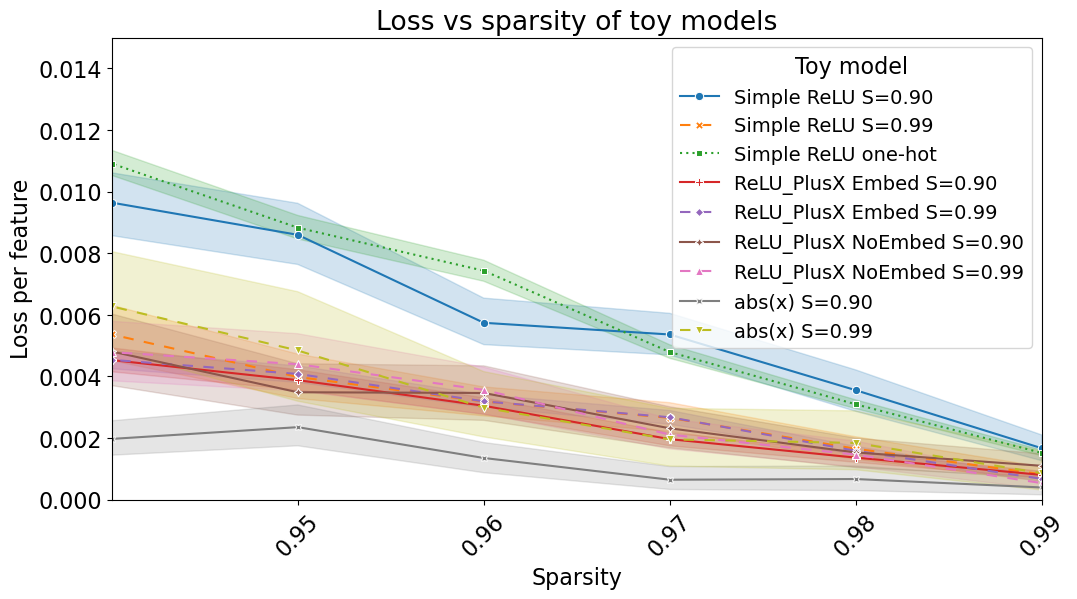

In [111]:
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='sparsity', y = "loss_per_feature", hue='source', 
             style= 'source', dashes=line_styles,markers=True)


# Customize legend
plt.legend(title="Toy model", fontsize = 14)

# Labels & Title
plt.xlabel("Sparsity")
plt.xticks(sparsities[sparsities > 0.94], rotation = 45)
plt.xlim(0.94,0.99)
plt.ylim(0,0.015)
plt.ylabel("Loss per feature")
plt.title("Loss vs sparsity of toy models")

# Save and show plot
plt.savefig("/workspace/toyModels_inferenceSparsity_loss_veryHighSv2.png", dpi=300)
plt.show()

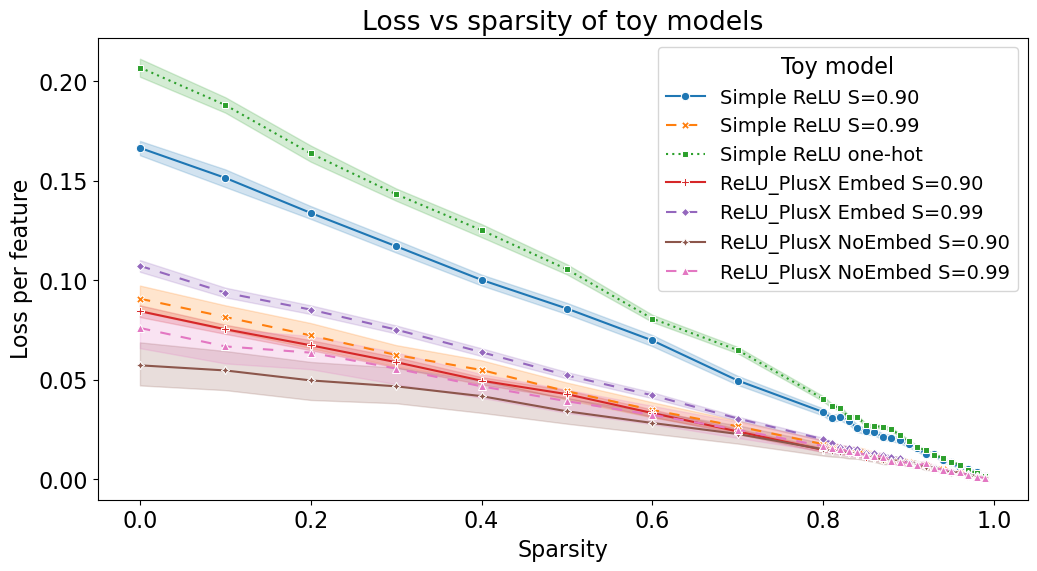

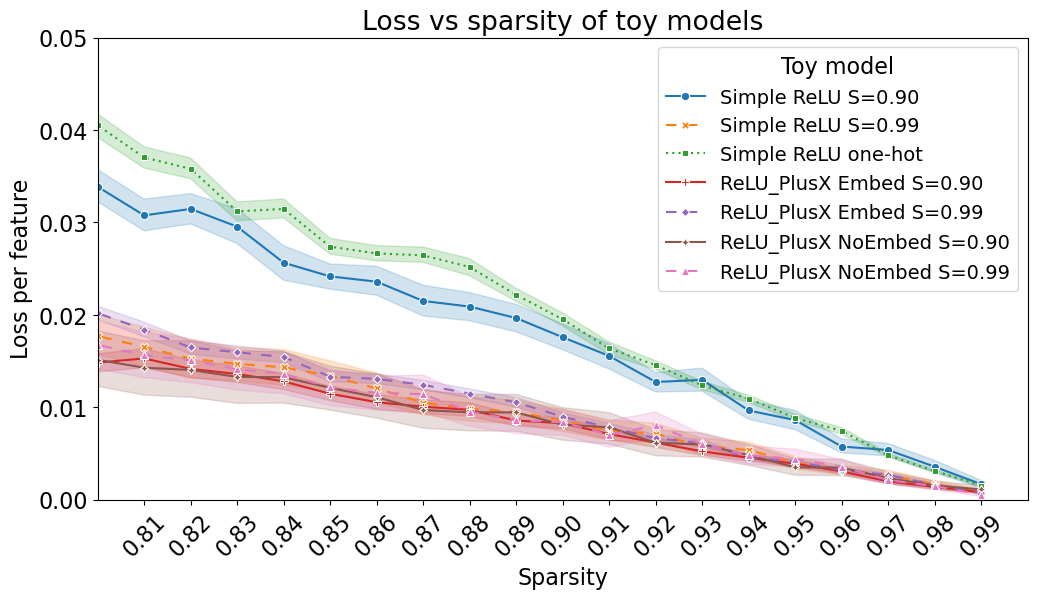

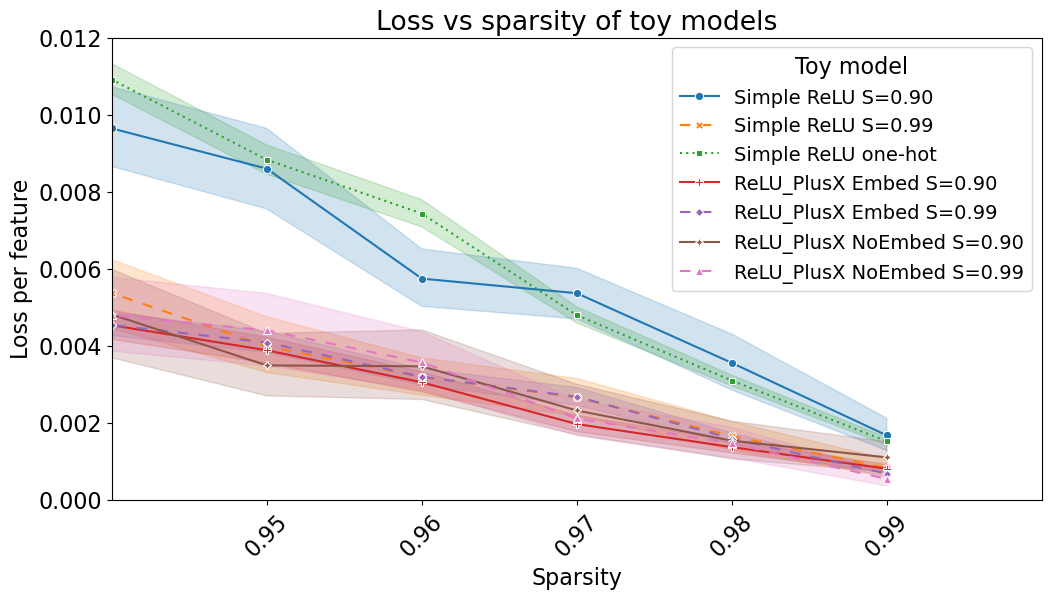

In [105]:
# plot results from all models except abs(x)
df_combined = pd.concat([df1, df2, df3, df4, df5, df6, df7])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='sparsity', y = "loss_per_feature", hue='source', 
             style= 'source', dashes=line_styles, markers=True) #palette=custom_palette, 


# Customize legend
plt.legend(title="Toy model", fontsize = 14)

# Labels & Title
plt.xlabel("Sparsity")
plt.ylabel("Loss per feature")
plt.title("Loss vs sparsity of toy models")

# Save and show plot
plt.savefig("/workspace/toyModelsWithoutAbs_inferenceSparsity_lossv2.png", dpi=300)
plt.show()


# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='sparsity', y = "loss_per_feature", hue='source', 
             style= 'source', dashes=line_styles, markers=True) #palette=custom_palette, 


# Customize legend
plt.legend(title="Toy model", fontsize = 14)

# Labels & Title
plt.xlabel("Sparsity")
plt.xticks(sparsities[sparsities > 0.8], rotation = 45)
plt.xlim(0.8,1)
plt.ylim(0,0.05)
plt.ylabel("Loss per feature")
plt.title("Loss vs sparsity of toy models")

# Save and show plot
plt.savefig("/workspace/toyModelsWithoutAbs_inferenceSparsity_loss_highSv2.png", dpi=300)
plt.show()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='sparsity', y = "loss_per_feature", hue='source', 
             style= 'source', dashes=line_styles, markers=True)# palette=custom_palette,


# Customize legend
plt.legend(title="Toy model", fontsize = 14)

# Labels & Title
plt.xlabel("Sparsity")
plt.xticks(sparsities[sparsities > 0.94], rotation = 45)
plt.xlim(0.94,1)
plt.ylim(0,0.012)
plt.ylabel("Loss per feature")
plt.title("Loss vs sparsity of toy models")

# Save and show plot
plt.savefig("/workspace/toyModelsWithoutAbs_inferenceSparsity_loss_veryHighSv2.png", dpi=300)
plt.show()